# Canary Models with Seldon and Istio

This folder provides resources to illustrate how to do a canary	roll out of one	MNIST model to another using the canary	pattern where a small amount	of traffic is sent to the new model to validate	it before sending all traffic to the new model.

We utilize two MNIST digit classification models. 

 * Version 1 of the model using scikit-learn
 * Version 2 of the model using Tensorflow.
 
After deploying Istio and Seldon to a kubernetes cluster we will:

 * Deploy version 1 scikit-learn based model using seldon-core
 * Create an istio routing rule to direct all traffic to this version
 * Create a canary deployment with both version 1 and version 2 (the Tensorflow model)
 * Update the istio routing to send 10% of the traffic to version 2
 * Update the istio routing to send 100% of the traffic to version 2
 
 

## Setup

The steps below will install istio and seldon onto a GKE Cluster. If you wish to use your own setup then you need to ensure

 * You allow istio egress to the internet as the load test downloads MNIST images
 * Ensure you give your user cluster-admin privledges
 * Install seldon into a namespace seldon
 
To follow the steps below you will need:
 
  * a Google project running a K8S cluster
  * gcloud and kubectl installed with kubectl authorized for your cluster
  * [istio download](https://github.com/istio/istio/releases/)

## Setup Environment Variables

In [1]:
# Set this to your istio download folder, e.g. 
# %env ISTIO_HOME=~/istio-1.0.0
%env ISTIO_HOME=/home/clive/work/istio/istio-1.0.6

env: ISTIO_HOME=/home/clive/work/istio/istio-1.0.6


In [2]:
# Set this to your GKE Zone for your cluster, e.g.
# %env ZONE=europe-west3-b
%env ZONE=europe-west3-b

env: ZONE=europe-west3-b


In [3]:
# Set this to the GCP Project within which your cluster is running
%env PROJECT=seldon-demos

env: PROJECT=seldon-demos


In [4]:
# Set this to the name of your kubernetes cluster
%env CLUSTER_NAME=istio-seldon

env: CLUSTER_NAME=istio-seldon


## Determine CIDR ranges

In [5]:
!gcloud container clusters describe ${CLUSTER_NAME} --zone ${ZONE} --project ${PROJECT} | grep -e clusterIpv4Cidr -e servicesIpv4Cidr

clusterIpv4Cidr: 10.56.0.0/14
servicesIpv4Cidr: 10.59.240.0/20


## Install Helm

In [6]:
!kubectl create clusterrolebinding my-cluster-admin-binding --clusterrole=cluster-admin --user=$(gcloud info --format="value(config.account)")

clusterrolebinding.rbac.authorization.k8s.io/my-cluster-admin-binding created


In [7]:
!kubectl create -f ${ISTIO_HOME}/install/kubernetes/helm/helm-service-account.yaml

serviceaccount/tiller created
clusterrolebinding.rbac.authorization.k8s.io/tiller created


In [8]:
!helm init --service-account tiller

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


## Install Istio


** Replace the CIDR 10.48.0.0/14\,10.51.240.0/20 values with those you got above **

For more details see [istio docs on egress](https://istio.io/docs/tasks/traffic-management/egress/#calling-external-services-directly)

In [10]:
!helm install ${ISTIO_HOME}/install/kubernetes/helm/istio --name istio --namespace istio-system \
    --set global.proxy.includeIPRanges="10.56.0.0/14\,10.59.240.0/20" --set grafana.enabled=true

NAME:   istio
LAST DEPLOYED: Thu Apr 25 10:19:44 2019
NAMESPACE: istio-system
STATUS: DEPLOYED

RESOURCES:
==> v1alpha2/stdio
NAME     AGE
handler  1m

==> v1beta1/Deployment
NAME                    DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
istio-galley            1        1        1           1          1m
istio-egressgateway     1        1        1           1          1m
istio-ingressgateway    1        1        1           1          1m
grafana                 1        1        1           1          1m
istio-telemetry         1        1        1           1          1m
istio-policy            1        1        1           1          1m
istio-pilot             1        1        1           1          1m
prometheus              1        1        1           1          1m
istio-citadel           1        1        1           1          1m
istio-sidecar-injector  1        1        1           0          1m

==> v1alpha3/Gateway
NAME                             AGE
istio-autogenerat

To view the istio Grafana dashboard:
```
kubectl -n istio-system port-forward $(kubectl -n istio-system get pod -l app=grafana -o jsonpath='{.items[0].metadata.name}') 3000:3000
```
http://localhost:3000

## Install Seldon

In [11]:
!kubectl create namespace seldon

namespace/seldon created


In [19]:
!helm install ../../../helm-charts/seldon-core-operator --name seldon-core --set usageMetrics.enabled=true --namespace seldon-system --set image.pullPolicy=Always

NAME:   seldon-core
LAST DEPLOYED: Thu Apr 25 12:22:54 2019
NAMESPACE: seldon-system
STATUS: DEPLOYED

RESOURCES:
==> v1/Secret
NAME                                   TYPE    DATA  AGE
seldon-operator-webhook-server-secret  Opaque  0     1s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  1s

==> v1/ClusterRole
seldon-operator-manager-role  1s

==> v1/ClusterRoleBinding
NAME                                 AGE
seldon-operator-manager-rolebinding  1s

==> v1/Service
NAME                                        TYPE       CLUSTER-IP     EXTERNAL-IP  PORT(S)  AGE
seldon-operator-controller-manager-service  ClusterIP  10.59.245.141  <none>       443/TCP  1s

==> v1/StatefulSet
NAME                                DESIRED  CURRENT  AGE
seldon-operator-controller-manager  1        1        1s

==> v1/Pod(related)
NAME                                  READY  STATUS             RESTARTS  AGE
seldon-operator-contro

In [20]:
!kubectl rollout status statefulset.apps/seldon-operator-controller-manager -n seldon-system 

Waiting for 1 pods to be ready...
partitioned roll out complete: 1 new pods have been updated...


## Setup Ingress
There are gRPC issues with the latest Ambassador, so we rewcommend 0.40.2 until these are fixed.

In [5]:
!helm install stable/ambassador --name ambassador --set image.tag=0.40.2

NAME:   ambassador
LAST DEPLOYED: Thu Apr 25 11:42:30 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/ServiceAccount
NAME        SECRETS  AGE
ambassador  1        0s

==> v1beta1/ClusterRole
NAME        AGE
ambassador  0s

==> v1beta1/ClusterRoleBinding
NAME        AGE
ambassador  0s

==> v1/Service
NAME               TYPE          CLUSTER-IP     EXTERNAL-IP  PORT(S)                     AGE
ambassador-admins  ClusterIP     10.59.242.87   <none>       8877/TCP                    0s
ambassador         LoadBalancer  10.59.245.210  <pending>    80:32194/TCP,443:31903/TCP  0s

==> v1/Deployment
NAME        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
ambassador  3        3        3           0          0s

==> v1/Pod(related)
NAME                         READY  STATUS             RESTARTS  AGE
ambassador-7fb5454fb8-c94kt  0/1    ContainerCreating  0         0s
ambassador-7fb5454fb8-jcbgx  0/1    ContainerCreating  0         0s
ambassador-7fb5454fb8-nxkq5  0/1    ContainerCreatin

In [6]:
!kubectl rollout status deployment.apps/ambassador

deployment "ambassador" successfully rolled out


## Add Seldon Analytics

In [19]:
!helm install ../../../helm-charts/seldon-core-analytics --name seldon-core-analytics \
    --set grafana_prom_admin_password=password \
    --set persistence.enabled=false \
    --namespace seldon

NAME:   seldon-core-analytics
LAST DEPLOYED: Thu Apr 25 10:25:44 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ServiceAccount
NAME        SECRETS  AGE
prometheus  1        4s

==> v1beta1/Deployment
NAME                     DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
alertmanager-deployment  1        1        1           0          4s
grafana-prom-deployment  1        1        1           0          4s
prometheus-deployment    1        1        1           0          4s

==> v1beta1/DaemonSet
NAME                      DESIRED  CURRENT  READY  UP-TO-DATE  AVAILABLE  NODE SELECTOR  AGE
prometheus-node-exporter  3        3        3      3           3          <none>         4s

==> v1/Secret
NAME                 TYPE    DATA  AGE
grafana-prom-secret  Opaque  1     4s

==> v1/ConfigMap
NAME                       DATA  AGE
alertmanager-server-conf   1     4s
grafana-import-dashboards  11    4s
prometheus-rules           0     4s
prometheus-server-conf     1     4s

==> v1beta1

To send requests to Ambassador ingress in another terminal run:
    
```
kubectl port-forward $(kubectl get pods -n default -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n default 8002:8080
```

To view the Seldon Grafana dashboard in another terminal run:

```
kubectl port-forward $(kubectl get pods -n seldon -l app=grafana-prom-server -o jsonpath='{.items[0].metadata.name}') -n seldon 3001:3000
```

Use user:admin and the password passed in above in the helm install.

http://localhost:3001/dashboard/db/prediction-analytics?refresh=5s&orgId=1

In [7]:
!kubectl label namespace seldon istio-injection=enabled

namespace/seldon labeled


In [8]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "gke_seldon-demos_europe-west3-b_istio-seldon" modified.


In [1]:
%matplotlib inline
import utils
from visualizer import get_graph
mnist = utils.download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Launch Version 1 Model
A sklearn MNIST model.

In [10]:
!pygmentize mnist_v1.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Mnist classification"
        },
        "name": "mnist-deployment",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/sk-example-mnist:0.2",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "sk-mnist-classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                    

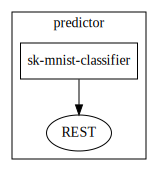

In [21]:
get_graph("mnist_v1.json")

In [22]:
!kubectl apply -f mnist_v1.json

seldondeployment.machinelearning.seldon.io/mnist-classifier created


** Wait until new pods are running **

In [23]:
!kubectl rollout status deploy/mnist-deployment-sk-mnist-predictor-73d7608

Waiting for deployment "mnist-deployment-sk-mnist-predictor-73d7608" rollout to finish: 0 of 1 updated replicas are available...
deployment "mnist-deployment-sk-mnist-predictor-73d7608" successfully rolled out


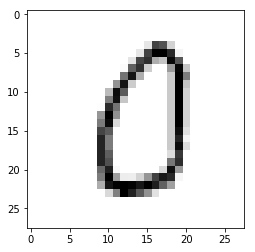

Route:{}
{
  "class:0": "0.83",
  "class:1": "0.00",
  "class:2": "0.03",
  "class:3": "0.03",
  "class:4": "0.00",
  "class:5": "0.03",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.03",
  "class:9": "0.03"
}


In [24]:
utils.predict_rest_mnist(mnist,"mnist-classifier","seldon")

## Start a Load Test

In [3]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

node/gke-istio-seldon-default-pool-ccf7a8c0-dw24 labeled


In [25]:
!helm install seldon-core-loadtesting --name loadtest  \
    --namespace seldon \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://mnist-deployment-mnist-classifier:8000 \
    --set oauth.enabled=false \
    --set oauth.key=oauth-key \
    --set oauth.secret=oauth-secret \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Thu Apr 25 12:24:49 2019
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Service
NAME             TYPE      CLUSTER-IP    EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.59.244.87  <none>       5557:32054/TCP,5558:30083/TCP,8089:30724/TCP  0s

==> v1/Pod(related)
NAME                   READY  STATUS    RESTARTS  AGE
locust-slave-1-6d69q   0/2    Init:0/1  0         0s
locust-master-1-4fcz9  0/2    Init:0/1  0         0s

==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-slave-1   1        1        0      0s
locust-master-1  1        1        0      0s




## Setup Version 1 Istio Routing

Just route to version 1 of our model

In [5]:
!pygmentize istio_canary_v1.yaml

apiVersion: networking.istio.io/v1alpha3
kind: VirtualService
metadata:
  name: mnist-deployment
  namespace: seldon
spec:
  hosts:
  - mnist-deployment-mnist-classifier
  http:
  - route:
    - destination:
        host: mnist-deployment-mnist-classifier
        subset: v1
---
apiVersion: networking.istio.io/v1alpha3
kind: DestinationRule
metadata:
  name: mnist-deployment
  namespace: seldon  
spec:
  host: mnist-deployment-mnist-classifier
  subsets:
  - name: v1
    labels:
      version: v1
  - name: v2
    labels:
      version: v2
---


In [29]:
!istioctl create -f istio_canary_v1.yaml

Updated config virtual-service/seldon/mnist-deployment to revision 23194
Updated config destination-rule/seldon/mnist-deployment to revision 18078


## Launch Version 2 of Model

Version 2 is a Tensorflow Deep Learning Model for MNIST. Hopefully, better...

In [7]:
!pygmentize mnist_v2.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Mnist classification"
        },
        "name": "mnist-deployment",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/sk-example-mnist:0.2",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "sk-mnist-classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                    

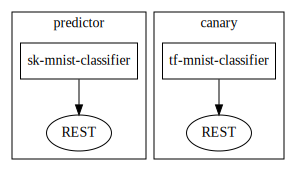

In [8]:
get_graph("mnist_v2.json")

In [30]:
!kubectl apply -f mnist_v2.json

seldondeployment.machinelearning.seldon.io/mnist-classifier configured


** Wait until new pods are running **

In [31]:
!kubectl rollout status deploy/mnist-deployment-tf-mnist-predictor-30ee1e9

Waiting for deployment "mnist-deployment-tf-mnist-predictor-30ee1e9" rollout to finish: 0 of 1 updated replicas are available...
deployment "mnist-deployment-tf-mnist-predictor-30ee1e9" successfully rolled out


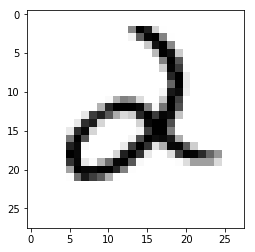

Route:{}
{
  "class:0": "0.07",
  "class:1": "0.03",
  "class:2": "0.27",
  "class:3": "0.00",
  "class:4": "0.17",
  "class:5": "0.10",
  "class:6": "0.23",
  "class:7": "0.00",
  "class:8": "0.10",
  "class:9": "0.03"
}


In [32]:
utils.predict_rest_mnist(mnist,"mnist-classifier","seldon")

## Setup Canary Routing

Let's be cautious and route 30% of traffic to version 2

In [33]:
!pygmentize istio_canary_v2.yaml

apiVersion: networking.istio.io/v1alpha3
kind: VirtualService
metadata:
  name: mnist-deployment
  namespace: seldon
spec:
  hosts:
  - mnist-deployment-mnist-classifier
  http:
  - route:
    - destination:
        host: mnist-deployment-mnist-classifier
        subset: v1
      weight: 70
    - destination:
        host: mnist-deployment-mnist-classifier
        subset: v2
      weight: 30      
---
apiVersion: networking.istio.io/v1alpha3
kind: DestinationRule
metadata:
  name: mnist-deployment
  namespace: seldon  
spec:
  host: mnist-deployment-mnist-classifier
  subsets:
  - name: v1
    labels:
      version: v1
  - name: v2
    labels:
      version: v2
---


In [34]:
!istioctl replace -f istio_canary_v2.yaml

Updated config virtual-service/seldon/mnist-deployment to revision 23464
Updated config destination-rule/seldon/mnist-deployment to revision 18078


Viewing the Seldon Grafana dashboard we see both models getting traffic.

![dashboard](dashboard.png)

## Setup Routing to Version 2

After testing we are happy and want to switch 100% of traffic to version 2 our Tensorflow model.

In [35]:
!pygmentize istio_canary_v3.yaml

apiVersion: networking.istio.io/v1alpha3
kind: VirtualService
metadata:
  name: mnist-deployment
  namespace: seldon
spec:
  hosts:
  - mnist-deployment-mnist-classifier
  http:
  - route:
    - destination:
        host: mnist-deployment-mnist-classifier
        subset: v2
---
apiVersion: networking.istio.io/v1alpha3
kind: DestinationRule
metadata:
  name: mnist-deployment
  namespace: seldon  
spec:
  host: mnist-deployment-mnist-classifier
  subsets:
  - name: v1
    labels:
      version: v1
  - name: v2
    labels:
      version: v2
---


In [36]:
!istioctl replace -f istio_canary_v3.yaml

Updated config virtual-service/seldon/mnist-deployment to revision 23558
Updated config destination-rule/seldon/mnist-deployment to revision 18078


The dashboard now show traffic 100% to our new model.

![dashboard2](dashboard2.png)

## Switch to final model

Finally, lets save resources and remove version 1 of our model

In [71]:
!pygmentize mnist_v3.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Mnist classification"
        },
        "name": "mnist-deployment",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/tf-example-mnist:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "tf-mnist-classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                    

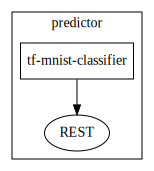

In [37]:
get_graph("mnist_v3.json")

In [38]:
!kubectl apply -f mnist_v3.json

seldondeployment.machinelearning.seldon.io/mnist-classifier configured
